In [1]:
import glob
import re
import pickle
import collections
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix

%matplotlib inline

In [2]:
data_path = 'data/'

In [3]:
files = glob.glob(data_path + '/*')

In [4]:
files

['data\\testing.res', 'data\\training.res']

In [5]:
train = pickle.load(open(files[1], 'rb'))
test = pickle.load(open(files[0], 'rb'))

In [6]:
d_train = pd.DataFrame({'content': train[0], 'label': train[1]})
d_test = pd.DataFrame({'content': test[0], 'label': test[1]})

In [9]:
d_train.shape

(6127, 2)

In [10]:
d_test.shape

(2627, 2)

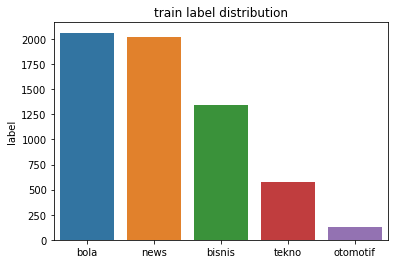

In [7]:
train_plot = sns.barplot(y = d_train.label.value_counts(), x = d_train.label.value_counts().index).set_title('train label distribution')
train_plot.get_figure().savefig('train_dist.png')

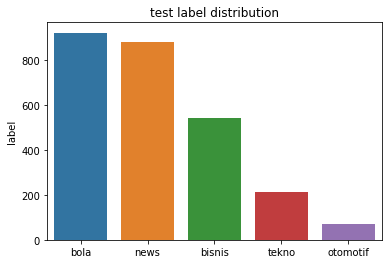

In [8]:
test_plot = sns.barplot(y = d_test.label.value_counts(), x = d_test.label.value_counts().index).set_title('test label distribution')
test_plot.get_figure().savefig('test_dist.png')

## cleansing

In [11]:
def get_frequent_word(df):
    text = " ".join(list(df['content'].str.lower()))
    word_list = word_tokenize(text)
    word_count = dict(collections.Counter(word_list))
    d_word_freq = pd.DataFrame(data = {'word': list(word_count.keys()), 'freq': list(word_count.values())})
    
    return d_word_freq

In [13]:
def cleansing(text, stopword = None):
    word_list = word_tokenize(text.lower())
    word_list = [word for word in word_list if len(word) > 2]
    word_list = [word for word in word_list if word.isalnum()]
    if stopword == None:
        text = ' '.join(word_list)
    else:
        word_list = [word for word in word_list if word not in stopword]
        text = ' '.join(word_list)
                
    return text

In [14]:
d_w_f = get_frequent_word(d_train)

In [15]:
d_w_f['is_alnum'] = d_w_f.word.str.isalnum()

In [16]:
d_w_f_selected = d_w_f[d_w_f['is_alnum'] == True].sort_values(by = 'freq', ascending = False)

In [19]:
stopwords = list(d_w_f_selected[(d_w_f_selected['freq'] > 5000) | (d_w_f_selected['freq'] < 2)].word)

In [22]:
for i in tqdm(range(len(d_train))):
    d_train.loc[i, 'content_cleansing'] = cleansing(d_train.loc[i, 'content'], stopword=stopwords)

100%|██████████████████████████████████████████████████████████████████████████████| 6127/6127 [07:48<00:00, 12.83it/s]


In [24]:
for i in tqdm(range(len(d_test))):
    d_test.loc[i, 'content_cleansing'] = cleansing(d_test.loc[i, 'content'], stopword=stopwords)

100%|██████████████████████████████████████████████████████████████████████████████| 2627/2627 [03:22<00:00, 10.77it/s]


In [25]:
for i in tqdm(range(len(d_train))):
    d_train.loc[i, 'content_cleansing_stopword'] = cleansing(d_train.loc[i, 'content'], stopword=None)

100%|█████████████████████████████████████████████████████████████████████████████| 6127/6127 [00:42<00:00, 143.13it/s]


In [26]:
for i in tqdm(range(len(d_test))):
    d_test.loc[i, 'content_cleansing_stopword'] = cleansing(d_test.loc[i, 'content'], stopword=None)

 43%|█████████████████████████████████                                            | 2626/6127 [00:14<00:20, 169.50it/s]

KeyError: 2627

 43%|█████████████████████████████████                                            | 2626/6127 [00:30<00:20, 169.50it/s]

## feature extraction

In [27]:
def fe(train_content, test_content):
    cv = CountVectorizer()
    X_train = cv.fit_transform(train_content)
    X_test = cv.transform(test_content)
    
    return cv, X_train, X_test

In [44]:
cv, X_train, X_test = fe(d_train.content_cleansing, d_test.content_cleansing)

cv_sw, X_train_sw, X_test_sw = fe(d_train.content_cleansing_stopword, d_test.content_cleansing_stopword)

## model

In [45]:
mnb = MultinomialNB()

mnb.fit(X_train, d_train.label)

y_pred = mnb.predict(X_test)

In [47]:
mnb_sw = MultinomialNB()

mnb_sw.fit(X_train_sw, d_train.label)

y_pred_sw = mnb_sw.predict(X_test_sw)

## evaluation

In [48]:
def evaluation(y_true, y_pred, label):
    f1score = f1_score(y_true, y_pred, average='macro')

    recall = recall_score(y_true, y_pred, average='macro')

    precision = precision_score(y_true, y_pred, average='macro')
    
    cm = confusion_matrix(y_true, y_pred, labels = label)
    
    return f1score, recall, precision, cm

In [49]:
label = list(d_test.label.value_counts().index)

In [50]:
label

['bola', 'news', 'bisnis', 'tekno', 'otomotif']

In [96]:
f1score, recall, precision, cm = evaluation(d_test.label, y_pred, label)

In [88]:
print(" f1-score: {}\n precision: {}\n recall: {}\n".format(f1score, precision, recall))

 f1-score: 0.8980554588622012
 precision: 0.9228394543988319
 recall: 0.8813724788831356



In [89]:
label_true = [l + "_actual" for l in label]

In [90]:
pd.DataFrame(data = cm, columns=label, index=label_true)

,bola,news,bisnis,tekno,otomotif
bola_actual,893,20,3,6,1
news_actual,8,798,71,3,0
bisnis_actual,4,36,492,10,0
tekno_actual,0,8,14,190,0
otomotif_actual,0,6,9,4,51


In [97]:
f1score_, recall_, precision_, cm_ = evaluation(d_test.label, y_pred_sw, label)

In [92]:
print(" f1-score: {}\n precision: {}\n recall: {}".format(f1score, precision, recall))

 f1-score: 0.8600383411291406
 precision: 0.9184387842440312
 recall: 0.8336679198085388


In [93]:
pd.DataFrame(data = cm, columns=label, index=label_true)

,bola,news,bisnis,tekno,otomotif
bola_actual,894,20,3,6,0
news_actual,8,799,71,2,0
bisnis_actual,4,36,493,9,0
tekno_actual,1,10,17,184,0
otomotif_actual,0,9,14,11,36


In [98]:
score_list = [{'f1-score': f1score, 'precision': precision, 'recall': recall},
 {'f1-score': f1score_, 'precision': precision_, 'recall': recall_}]

In [100]:
pd.DataFrame(score_list, index = ['without stopwords', 'with stopwords'])

,f1-score,precision,recall
without stopwords,0.898055,0.922839,0.881372
with stopwords,0.860038,0.918439,0.833668
